In [1]:
# Standard Libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep Learning and PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
# Image Processing
from PIL import Image
from torchvision import transforms, models

# File Handling
import h5py

# Metrics and Evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Progress Visualization
from tqdm import tqdm



## Create Custom Dataset

In [2]:

class MultiInputDataset(Dataset):
    def __init__(self, hdf5_file, csv_file, transform=None):
        # Open the HDF5 file with error handling
        try:
            self.hdf5_file = h5py.File(hdf5_file, 'r')  # Read-only mode
        except Exception as e:
            raise IOError(f"Could not open HDF5 file: {hdf5_file}. Error: {e}")

        # Read the CSV file containing image labels and additional features
        try:
            self.labels_df = pd.read_csv(csv_file)
        except Exception as e:
            raise IOError(f"Could not read CSV file: {csv_file}. Error: {e}")

        # Ensure that all image IDs from the CSV are present in the HDF5 file
        self.image_ids = self.labels_df['isic_id'].values
        for image_id in self.image_ids:
            if str(image_id) not in self.hdf5_file.keys():
                raise ValueError(f"Image id {image_id} not found in HDF5 file.")

        # Store any transformations to be applied to the images
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get the image ID from the CSV file based on index
        image_id = str(self.labels_df.iloc[idx]['isic_id'])

        # Load the image data from the HDF5 file
        image_bytes = self.hdf5_file[image_id][()]

        # Convert the image bytes to a PIL Image
        image = Image.open(io.BytesIO(image_bytes))

        # Apply any specified transformations to the image
        if self.transform:
            image = self.transform(image)

        # Retrieve the label
        label = torch.tensor(self.labels_df.iloc[idx]['target'], dtype=torch.long)  # Adjust dtype if needed

        # Retrieve other features, excluding 'isic_id' and 'target'
        other_variables = self.labels_df.iloc[idx].drop(['isic_id', 'target']).values.astype(float)

        # Convert other variables (metadata) to a tensor
        metadata_tensor = torch.tensor(other_variables, dtype=torch.float32)

        # Return the image, metadata, and label
        return image, metadata_tensor, label


In [3]:


def get_train_transform(resize_size=(224, 224), crop_size=128, rotation_degree=10, normalize_means=(0.5, 0.5, 0.5), normalize_stds=(0.5, 0.5, 0.5)):
    """
    Returns the transformations for the training dataset, including data augmentation.

    Args:
        resize_size (tuple): The size to resize the image before cropping.
        crop_size (int): The size of the random crop.
        rotation_degree (int): Maximum degree for random rotation.
        normalize_means (tuple): Means for normalization.
        normalize_stds (tuple): Standard deviations for normalization.

    Returns:
        transforms.Compose: The composed transformations for the training set.
    """
    return transforms.Compose([
        transforms.Resize(resize_size),  # Resize to specified size
        transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),  # Random crop with scale
        transforms.RandomRotation(rotation_degree),  # Randomly rotate images
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(normalize_means, normalize_stds)  # Normalize with specified means and stds
    ])

def get_normal_transform(resize_size=(224, 224), normalize_means=(0.5, 0.5, 0.5), normalize_stds=(0.5, 0.5, 0.5)):
    """
    Returns the transformations for the validation/test dataset (without data augmentation).

    Args:
        resize_size (tuple): The size to resize the image.
        normalize_means (tuple): Means for normalization.
        normalize_stds (tuple): Standard deviations for normalization.

    Returns:
        transforms.Compose: The composed transformations for the validation/test set.
    """
    return transforms.Compose([
        transforms.Resize(resize_size),  # Resize to specified size
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize(normalize_means, normalize_stds)  # Normalize with specified means and stds
    ])





## Train DataLoader

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model Building

In [5]:
# CNN Model
class CustomImageFeatureCNN2(nn.Module):
    def __init__(self, feature_input_size, input_image_size=(128, 128)):
        super(CustomImageFeatureCNN2, self).__init__()

        # Image CNN with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 Max pooling

        # Dynamically calculate the flattened size of the feature map
        self.flattened_size = self._get_flattened_size(input_image_size)

        # Fully connected layer after the CNN layers
        self.fc_image = nn.Linear(self.flattened_size, 512)

        # Fully connected layer for metadata (feature data)
        self.fc_metadata = nn.Linear(feature_input_size, 128)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)  # 50% dropout

        # Final fully connected layer for binary classification (combined image + feature input)
        self.fc_combined = nn.Linear(512 + 128, 1)  # Change 2 to 1 for binary classification

    def _get_flattened_size(self, input_image_size):
        # Forward pass a dummy image to get the size of the flattened features
        dummy_image = torch.zeros(1, 3, *input_image_size)  # Batch size of 1, 3 channels (RGB), and input size
        x = self.pool(F.relu(self.bn1(self.conv1(dummy_image))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x.view(-1).shape[0]  # Flatten and return the size

    def forward(self, image, metadata):
        # Forward pass for the image through the CNN
        x = self.pool(F.relu(self.bn1(self.conv1(image))))  # Conv layer 1 with ReLU, BatchNorm, MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv layer 2 with ReLU, BatchNorm, MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv layer 3 with ReLU, BatchNorm, MaxPool

        # Flatten the feature map to feed into fully connected layer
        x = x.view(x.size(0), -1)  # Flatten feature maps into a 1D vector
        image_features = F.relu(self.fc_image(x))

        # Process metadata (feature data)
        metadata_features = F.relu(self.fc_metadata(metadata))

        # Ensure the batch sizes are consistent
        assert image_features.shape[0] == metadata_features.shape[0], \
            f"Batch sizes do not match! Image batch size: {image_features.shape[0]}, Metadata batch size: {metadata_features.shape[0]}"

        # Concatenate image features and metadata features
        combined_features = torch.cat((image_features, metadata_features), dim=1)

        # Dropout and final classification layer
        combined_features = self.dropout(combined_features)
        output = self.fc_combined(combined_features)

        # If you're using BCELoss, uncomment the next line to apply sigmoid
        output = torch.sigmoid(output)

        return output

In [6]:
# Resnet Model
class CustomImageFeatureResNet(nn.Module):
    def __init__(self, feature_input_size, pretrained=True):
        super(CustomImageFeatureResNet, self).__init__()

        # Load a pretrained ResNet model for image feature extraction (ResNet18 in this case)
        resnet = models.resnet18(pretrained=pretrained)  # Change to resnet50, resnet101 as needed
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the final classification layer

        # The output of ResNet18's last conv layer is 512-dimensional (for ResNet50, it would be 2048)
        self.fc_image = nn.Linear(resnet.fc.in_features, 512)  # Adjust if using ResNet50

        # Fully connected layer for metadata (feature data)
        self.fc_metadata = nn.Linear(feature_input_size, 128)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)  # 50% dropout

        # Final fully connected layer for binary classification (combined image + feature input)
        self.fc_combined = nn.Linear(512 + 128, 1)  # For binary classification

    def forward(self, image, metadata):
        # Forward pass for the image through the ResNet (without the final classification layer)
        x = self.resnet(image)  # ResNet feature extraction
        x = x.view(x.size(0), -1)  # Flatten the ResNet output
        image_features = F.relu(self.fc_image(x))

        # Process metadata (feature data)
        metadata_features = F.relu(self.fc_metadata(metadata))

        # Ensure the batch sizes are consistent
        assert image_features.shape[0] == metadata_features.shape[0], \
            f"Batch sizes do not match! Image batch size: {image_features.shape[0]}, Metadata batch size: {metadata_features.shape[0]}"

        # Concatenate image features and metadata features
        combined_features = torch.cat((image_features, metadata_features), dim=1)

        # Dropout and final classification layer
        combined_features = self.dropout(combined_features)
        output = self.fc_combined(combined_features)

        # If you're using BCELoss, uncomment the next line to apply sigmoid
        output = torch.sigmoid(output)

        return output

In [7]:
# EfficientNet Model
class CustomImageFeatureEfficientNet(nn.Module):
    def __init__(self, feature_input_size, pretrained=True):
        super(CustomImageFeatureEfficientNet, self).__init__()

        # Load a pretrained EfficientNet model for image feature extraction (EfficientNet-B0 in this case)
        efficientnet = models.efficientnet_b0(pretrained=pretrained)  # You can change this to another EfficientNet version like B1 or B7
        self.efficientnet = nn.Sequential(*list(efficientnet.children())[:-1])  # Remove the final classification layer

        # The output of EfficientNet-B0's last conv layer is 1280-dimensional
        self.fc_image = nn.Linear(1280, 512)  # Reduce dimension to match your custom architecture

        # Fully connected layer for metadata (feature data)
        self.fc_metadata = nn.Linear(feature_input_size, 128)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)  # 50% dropout

        # Final fully connected layer for binary classification (combined image + feature input)
        self.fc_combined = nn.Linear(512 + 128, 1)  # For binary classification

    def forward(self, image, metadata):
        # Forward pass for the image through EfficientNet (without the final classification layer)
        x = self.efficientnet(image)  # EfficientNet feature extraction
        x = x.view(x.size(0), -1)  # Flatten the EfficientNet output
        image_features = F.relu(self.fc_image(x))

        # Process metadata (feature data)
        metadata_features = F.relu(self.fc_metadata(metadata))

        # Ensure the batch sizes are consistent
        assert image_features.shape[0] == metadata_features.shape[0], \
            f"Batch sizes do not match! Image batch size: {image_features.shape[0]}, Metadata batch size: {metadata_features.shape[0]}"

        # Concatenate image features and metadata features
        combined_features = torch.cat((image_features, metadata_features), dim=1)

        # Dropout and final classification layer
        combined_features = self.dropout(combined_features)
        output = self.fc_combined(combined_features)

        # If you're using BCELoss, uncomment the next line to apply sigmoid
        output = torch.sigmoid(output)

        return output


## Model Training

In [8]:
# Function to compute partial AUC-above-TPR
def score(solution: np.array, submission: np.array, min_tpr: float = 0.80) -> float:
    """
    Compute the partial AUC by focusing on a specific range of true positive rates (TPR).
    
    Args:
        solution (np.array): Ground truth binary labels.
        submission (np.array): Model predictions.
        min_tpr (float): Minimum true positive rate to calculate partial AUC.
    
    Returns:
        float: The calculated partial AUC.
    
    Raises:
        ValueError: If the min_tpr is not within a valid range.
    """
    # Rescale the target to handle sklearn limitations and flip the predictions
    v_gt = abs(solution - 1)
    v_pred = -1.0 * submission
    max_fpr = abs(1 - min_tpr)

    # Compute ROC curve using sklearn
    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError(f"Expected min_tpr in range [0, 1), got: {min_tpr}")
    
    # Interpolate for partial AUC
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc

# Training and validation loop function
def train_and_validate(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    best_model_path: str,
    early_stopping_patience: int = 5,
    min_tpr: float = 0.80
    
) -> nn.Module:
    """
    Train and validate a PyTorch model with early stopping, AUROC, partial AUC, and error handling.

    Args:
        model (nn.Module): The model to be trained and validated.
        train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
        val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer to update the model.
        epochs (int): Number of training epochs.
        device (torch.device): The device (CPU or GPU) to use.
        early_stopping_patience (int): Early stopping patience.
        min_tpr (float): The minimum true positive rate for calculating partial AUC.
    
    Returns:
        nn.Module: The trained model.
    """
    # Initialize tracking variables
    best_val_loss = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping_counter = 0

    # Start the training and validation loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_probs = []

        progress_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}')

        try:
            # Loop through the training batches
            for i, (image, metadata, labels) in enumerate(progress_bar):
                image, metadata, labels = image.to(device), metadata.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1)  # Adjust labels to have the right shape for binary classification

                optimizer.zero_grad()

                # Forward pass
                probs = model(image, metadata)

                if probs.shape != labels.shape:
                    raise ValueError(f"Shape mismatch: Predictions shape {probs.shape} does not match labels shape {labels.shape}")

                # Calculate loss and backpropagate
                loss = criterion(probs, labels)
                loss.backward()
                optimizer.step()

                # Update running loss
                running_train_loss += loss.item()

                # Store labels and predictions for accuracy calculations
                all_train_labels.extend(labels.cpu().detach().numpy())
                all_train_probs.extend(probs.cpu().detach().numpy())

                # Calculate binary predictions for training accuracy
                predicted_train = (probs >= 0.5).float()
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

                # Update progress bar
                progress_bar.set_postfix(train_loss=running_train_loss / (i + 1))

            # Calculate training accuracy and loss
            train_accuracy = 100 * correct_train / total_train
            train_losses.append(running_train_loss / len(train_dataloader))
            train_accuracies.append(train_accuracy)

        except ValueError as ve:
            print(f"Error during training loop: {ve}")
            break

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []

        progress_bar = tqdm(val_dataloader, desc=f'Validating Epoch {epoch + 1}')

        with torch.no_grad():
            try:
                # Loop through the validation batches
                for i, (images, metadata, labels) in enumerate(progress_bar):
                    images, metadata, labels = images.to(device), metadata.to(device), labels.float().to(device)
                    labels = labels.unsqueeze(1)

                    probs = model(images, metadata)

                    loss = criterion(probs, labels)
                    running_val_loss += loss.item()

                    all_labels.extend(labels.cpu().detach().numpy())
                    all_probs.extend(probs.cpu().detach().numpy())

                    # Calculate binary predictions for validation accuracy
                    predicted = (probs >= 0.5).float()
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    progress_bar.set_postfix(val_loss=running_val_loss / (i + 1))

                val_accuracy = 100 * correct / total
                val_loss = running_val_loss / len(val_dataloader)
                val_accuracies.append(val_accuracy)
                val_losses.append(val_loss)

                # Calculate AUROC
                try:
                    valid_auroc = roc_auc_score(all_labels, all_probs)
                except ValueError as ve:
                    print(f"AUROC Calculation Error: {ve}")
                    valid_auroc = 0.0

                # Calculate partial AUC-above-TPR
                try:
                    partial_auroc = score(np.array(all_labels), np.array(all_probs), min_tpr=min_tpr)
                except ValueError as ve:
                    print(f"Partial AUC Calculation Error: {ve}")
                    partial_auroc = 0.0

                print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Val Accuracy: {val_accuracy:.2f}%, Val AUROC: {valid_auroc:.4f}, Partial AUROC: {partial_auroc:.4f}')    

                # Early stopping based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch + 1
                    early_stopping_counter = 0
                    torch.save(model.state_dict(), best_model_path)
                else:
                    early_stopping_counter += 1

                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

            except Exception as e:
                print(f"Error during validation loop: {e}")
                break

    print(f"Best Epoch: {best_epoch}, Best Validation Loss: {best_val_loss:.4f}")
    print('Training Complete')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Generate classification report
    try:
        print("Classification Report:")
        print(classification_report(all_labels, (np.array(all_probs) >= 0.5).astype(int), target_names=['Class 0', 'Class 1']))
    except Exception as e:
        print(f"Error generating classification report: {e}")

    return model



In [9]:
# Initialize the dataset
CNN_train_dataset = MultiInputDataset(hdf5_file='../data/raw/train_images.hdf5', csv_file='../data/processed/processed-train-metadata1.csv', transform=get_train_transform(resize_size=(128,128)))
CNN_val_dataset = MultiInputDataset(hdf5_file='../data/raw/validation_image.hdf5', csv_file='../data/processed/processed-validation-metadata1.csv', transform=get_normal_transform(resize_size=(128,128)))
# Create a DataLoader
CNN_train_dataloader = DataLoader(CNN_train_dataset,  batch_size=64, shuffle=True)
CNN_val_dataloader = DataLoader(CNN_val_dataset,  batch_size=64, shuffle=True)

In [10]:
# Initialize the dataset
resnet_train_dataset = MultiInputDataset(hdf5_file='../data/raw/train_images.hdf5', csv_file='../data/processed/processed-train-metadata1.csv', transform=get_train_transform(resize_size=(225,225)))
resnet_val_dataset = MultiInputDataset(hdf5_file='../data/raw/validation_image.hdf5', csv_file='../data/processed/processed-validation-metadata1.csv', transform=get_normal_transform(resize_size=(225,225)))
# Create a DataLoader
resnet_train_dataloader = DataLoader(resnet_train_dataset,  batch_size=64, shuffle=True)
resnet_val_dataloader = DataLoader(resnet_val_dataset,  batch_size=64, shuffle=True)

In [11]:
# Initialize the dataset
effnet_train_dataset = MultiInputDataset(hdf5_file='../data/raw/train_images.hdf5', csv_file='../data/processed/processed-train-metadata1.csv', transform=get_train_transform(resize_size=(224,224)))
effnet_val_dataset = MultiInputDataset(hdf5_file='../data/raw/validation_image.hdf5', csv_file='../data/processed/processed-validation-metadata1.csv', transform=get_normal_transform(resize_size=(224,224)))
# Create a DataLoader
effnet_train_dataloader = DataLoader(effnet_train_dataset,  batch_size=64, shuffle=True)
effnet_val_dataloader = DataLoader(effnet_val_dataset,  batch_size=64, shuffle=True)

## Model 1

In [12]:
model1 = CustomImageFeatureCNN2(feature_input_size=9)  # Assuming 9 features for metadata
model1.to(device)
# Initialize optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
best_model_path = "best_model1.pth"

Epoch 1/20


Validating Epoch 1: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it, val_loss=0.423]


Epoch [0/20], Train Loss: 4.1848, Val Loss: 0.4227, Val Accuracy: 90.81%, Val AUROC: 0.8038, Partial AUROC: 0.0749
Epoch 2/20


Validating Epoch 2: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, val_loss=0.358]


Epoch [1/20], Train Loss: 0.8297, Val Loss: 0.3575, Val Accuracy: 88.93%, Val AUROC: 0.7938, Partial AUROC: 0.0599
Epoch 3/20


Validating Epoch 3: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, val_loss=0.368]


Epoch [2/20], Train Loss: 0.4581, Val Loss: 0.3682, Val Accuracy: 87.92%, Val AUROC: 0.8200, Partial AUROC: 0.0693
Epoch 4/20


Validating Epoch 4: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it, val_loss=0.313]


Epoch [3/20], Train Loss: 0.4267, Val Loss: 0.3129, Val Accuracy: 88.52%, Val AUROC: 0.8165, Partial AUROC: 0.0715
Epoch 5/20


Validating Epoch 5: 100%|██████████| 24/24 [00:25<00:00,  1.04s/it, val_loss=0.363]


Epoch [4/20], Train Loss: 0.4409, Val Loss: 0.3627, Val Accuracy: 86.51%, Val AUROC: 0.8393, Partial AUROC: 0.0821
Epoch 6/20


Validating Epoch 6: 100%|██████████| 24/24 [00:25<00:00,  1.04s/it, val_loss=0.31] 


Epoch [5/20], Train Loss: 0.4213, Val Loss: 0.3103, Val Accuracy: 88.19%, Val AUROC: 0.8442, Partial AUROC: 0.0844
Epoch 7/20


Validating Epoch 7: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it, val_loss=0.291]


Epoch [6/20], Train Loss: 0.4014, Val Loss: 0.2913, Val Accuracy: 88.93%, Val AUROC: 0.8538, Partial AUROC: 0.0917
Epoch 8/20


Validating Epoch 8: 100%|██████████| 24/24 [00:49<00:00,  2.06s/it, val_loss=0.269]


Epoch [7/20], Train Loss: 0.3820, Val Loss: 0.2685, Val Accuracy: 88.86%, Val AUROC: 0.8516, Partial AUROC: 0.0890
Epoch 9/20


Validating Epoch 9: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it, val_loss=0.224]


Epoch [8/20], Train Loss: 0.3666, Val Loss: 0.2236, Val Accuracy: 91.14%, Val AUROC: 0.8624, Partial AUROC: 0.1020
Epoch 10/20


Validating Epoch 10: 100%|██████████| 24/24 [00:42<00:00,  1.77s/it, val_loss=0.289]


Epoch [9/20], Train Loss: 0.3605, Val Loss: 0.2888, Val Accuracy: 88.79%, Val AUROC: 0.8273, Partial AUROC: 0.0790
Epoch 11/20


Validating Epoch 11: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it, val_loss=0.209]


Epoch [10/20], Train Loss: 0.3460, Val Loss: 0.2089, Val Accuracy: 92.75%, Val AUROC: 0.8748, Partial AUROC: 0.1060
Epoch 12/20


Validating Epoch 12: 100%|██████████| 24/24 [00:54<00:00,  2.26s/it, val_loss=0.238]


Epoch [11/20], Train Loss: 0.3341, Val Loss: 0.2383, Val Accuracy: 91.28%, Val AUROC: 0.8747, Partial AUROC: 0.1048
Epoch 13/20


Validating Epoch 13: 100%|██████████| 24/24 [00:35<00:00,  1.49s/it, val_loss=0.187]


Epoch [12/20], Train Loss: 0.3399, Val Loss: 0.1871, Val Accuracy: 93.36%, Val AUROC: 0.8728, Partial AUROC: 0.1066
Epoch 14/20


Validating Epoch 14: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it, val_loss=0.277]


Epoch [13/20], Train Loss: 0.3402, Val Loss: 0.2766, Val Accuracy: 89.13%, Val AUROC: 0.8791, Partial AUROC: 0.1095
Epoch 15/20


Validating Epoch 15: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it, val_loss=0.283]


Epoch [14/20], Train Loss: 0.3327, Val Loss: 0.2826, Val Accuracy: 87.92%, Val AUROC: 0.8737, Partial AUROC: 0.1035
Epoch 16/20


Validating Epoch 16: 100%|██████████| 24/24 [00:44<00:00,  1.84s/it, val_loss=0.287]


Epoch [15/20], Train Loss: 0.3239, Val Loss: 0.2866, Val Accuracy: 88.05%, Val AUROC: 0.8761, Partial AUROC: 0.1093
Epoch 17/20


Validating Epoch 17: 100%|██████████| 24/24 [00:35<00:00,  1.50s/it, val_loss=0.269]


Epoch [16/20], Train Loss: 0.3074, Val Loss: 0.2691, Val Accuracy: 88.72%, Val AUROC: 0.8842, Partial AUROC: 0.1106
Epoch 18/20


Validating Epoch 18: 100%|██████████| 24/24 [00:36<00:00,  1.52s/it, val_loss=0.248]


Epoch [17/20], Train Loss: 0.2999, Val Loss: 0.2485, Val Accuracy: 90.81%, Val AUROC: 0.8738, Partial AUROC: 0.1037
Early stopping triggered at epoch 17
Best Epoch: 13, Best Validation Loss: 0.1871
Training Complete


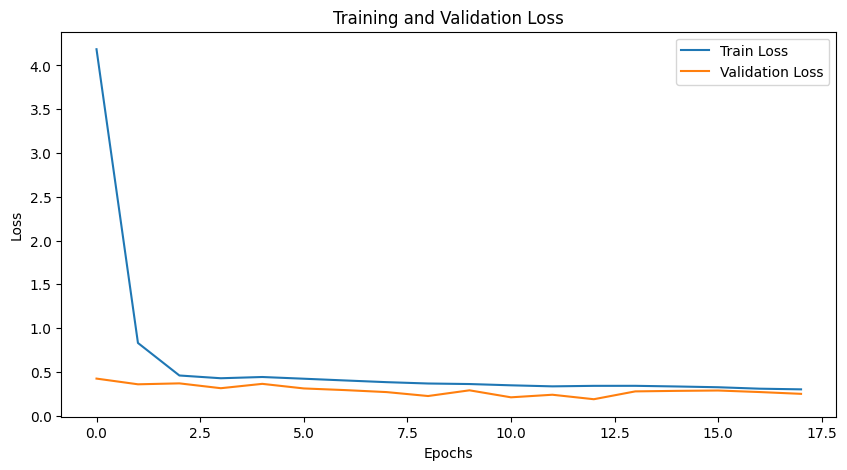

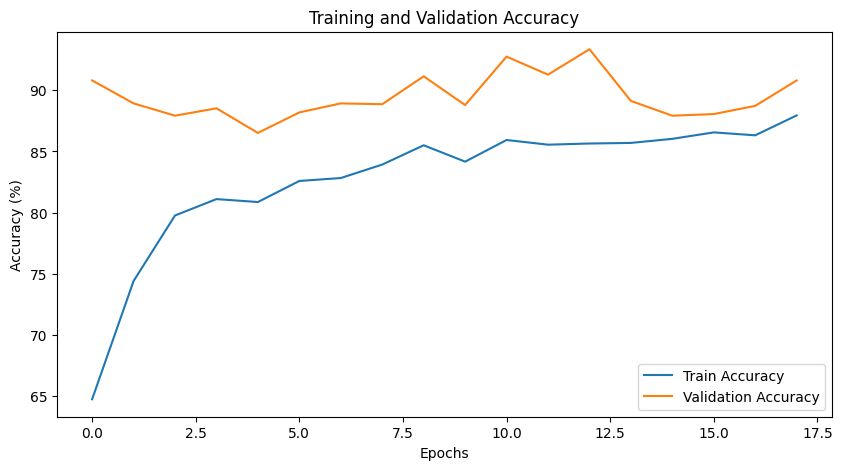

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.92      0.95      1431
     Class 1       0.25      0.68      0.37        59

    accuracy                           0.91      1490
   macro avg       0.62      0.80      0.66      1490
weighted avg       0.96      0.91      0.93      1490



CustomImageFeatureCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_image): Linear(in_features=32768, out_features=512, bias=True)
  (fc_metadata): Linear(in_features=9, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_combined): Linear(in_features=640, out_features=1, bias=True)
)

In [13]:
train_and_validate(model1,CNN_train_dataloader, CNN_val_dataloader, criterion, optimizer, epochs, device ,best_model_path)

## Model 2

In [14]:
model2 = CustomImageFeatureCNN2(feature_input_size=9)  # Assuming 9 features for metadata
model2.to(device)
# Initialize optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
best_model_path = "best_model2.pth"

Epoch 1/20


Validating Epoch 1: 100%|██████████| 24/24 [00:41<00:00,  1.75s/it, val_loss=0.57] 


Epoch [0/20], Train Loss: 0.6278, Val Loss: 0.5701, Val Accuracy: 95.97%, Val AUROC: 0.7021, Partial AUROC: 0.0547
Epoch 2/20


Validating Epoch 2: 100%|██████████| 24/24 [00:53<00:00,  2.22s/it, val_loss=0.496]


Epoch [1/20], Train Loss: 0.5989, Val Loss: 0.4958, Val Accuracy: 94.43%, Val AUROC: 0.7610, Partial AUROC: 0.0619
Epoch 3/20


Validating Epoch 3: 100%|██████████| 24/24 [00:38<00:00,  1.62s/it, val_loss=0.512]


Epoch [2/20], Train Loss: 0.5775, Val Loss: 0.5117, Val Accuracy: 88.93%, Val AUROC: 0.7735, Partial AUROC: 0.0635
Epoch 4/20


Validating Epoch 4: 100%|██████████| 24/24 [00:37<00:00,  1.58s/it, val_loss=0.482]


Epoch [3/20], Train Loss: 0.5548, Val Loss: 0.4821, Val Accuracy: 88.19%, Val AUROC: 0.7844, Partial AUROC: 0.0660
Epoch 5/20


Validating Epoch 5: 100%|██████████| 24/24 [00:38<00:00,  1.61s/it, val_loss=0.495]


Epoch [4/20], Train Loss: 0.5395, Val Loss: 0.4947, Val Accuracy: 84.09%, Val AUROC: 0.7909, Partial AUROC: 0.0696
Epoch 6/20


Validating Epoch 6: 100%|██████████| 24/24 [01:05<00:00,  2.74s/it, val_loss=0.507]


Epoch [5/20], Train Loss: 0.5253, Val Loss: 0.5066, Val Accuracy: 82.21%, Val AUROC: 0.7962, Partial AUROC: 0.0693
Epoch 7/20


Validating Epoch 7: 100%|██████████| 24/24 [00:37<00:00,  1.56s/it, val_loss=0.451]


Epoch [6/20], Train Loss: 0.5061, Val Loss: 0.4514, Val Accuracy: 84.90%, Val AUROC: 0.8026, Partial AUROC: 0.0705
Epoch 8/20


Validating Epoch 8: 100%|██████████| 24/24 [00:39<00:00,  1.64s/it, val_loss=0.492]


Epoch [7/20], Train Loss: 0.4968, Val Loss: 0.4923, Val Accuracy: 81.41%, Val AUROC: 0.8021, Partial AUROC: 0.0676
Epoch 9/20


Validating Epoch 9: 100%|██████████| 24/24 [00:38<00:00,  1.59s/it, val_loss=0.445]


Epoch [8/20], Train Loss: 0.4849, Val Loss: 0.4452, Val Accuracy: 84.43%, Val AUROC: 0.8091, Partial AUROC: 0.0722
Epoch 10/20


Validating Epoch 10: 100%|██████████| 24/24 [01:06<00:00,  2.79s/it, val_loss=0.484]


Epoch [9/20], Train Loss: 0.4712, Val Loss: 0.4843, Val Accuracy: 81.48%, Val AUROC: 0.8107, Partial AUROC: 0.0731
Epoch 11/20


Validating Epoch 11: 100%|██████████| 24/24 [00:38<00:00,  1.61s/it, val_loss=0.479]


Epoch [10/20], Train Loss: 0.4768, Val Loss: 0.4790, Val Accuracy: 81.14%, Val AUROC: 0.8137, Partial AUROC: 0.0748
Epoch 12/20


Validating Epoch 12: 100%|██████████| 24/24 [00:41<00:00,  1.72s/it, val_loss=0.448]


Epoch [11/20], Train Loss: 0.4682, Val Loss: 0.4476, Val Accuracy: 83.83%, Val AUROC: 0.8137, Partial AUROC: 0.0701
Epoch 13/20


Validating Epoch 13: 100%|██████████| 24/24 [00:38<00:00,  1.61s/it, val_loss=0.452]


Epoch [12/20], Train Loss: 0.4639, Val Loss: 0.4522, Val Accuracy: 82.75%, Val AUROC: 0.8171, Partial AUROC: 0.0733
Epoch 14/20


Validating Epoch 14: 100%|██████████| 24/24 [00:53<00:00,  2.21s/it, val_loss=0.42] 


Epoch [13/20], Train Loss: 0.4574, Val Loss: 0.4204, Val Accuracy: 84.83%, Val AUROC: 0.8185, Partial AUROC: 0.0722
Epoch 15/20


Validating Epoch 15: 100%|██████████| 24/24 [00:47<00:00,  1.99s/it, val_loss=0.428]


Epoch [14/20], Train Loss: 0.4527, Val Loss: 0.4277, Val Accuracy: 85.44%, Val AUROC: 0.8213, Partial AUROC: 0.0800
Epoch 16/20


Validating Epoch 16: 100%|██████████| 24/24 [00:45<00:00,  1.91s/it, val_loss=0.399]


Epoch [15/20], Train Loss: 0.4504, Val Loss: 0.3990, Val Accuracy: 85.97%, Val AUROC: 0.8235, Partial AUROC: 0.0766
Epoch 17/20


Validating Epoch 17: 100%|██████████| 24/24 [00:45<00:00,  1.90s/it, val_loss=0.407]


Epoch [16/20], Train Loss: 0.4443, Val Loss: 0.4070, Val Accuracy: 85.23%, Val AUROC: 0.8227, Partial AUROC: 0.0734
Epoch 18/20


Validating Epoch 18: 100%|██████████| 24/24 [00:43<00:00,  1.83s/it, val_loss=0.406]


Epoch [17/20], Train Loss: 0.4394, Val Loss: 0.4057, Val Accuracy: 85.70%, Val AUROC: 0.8271, Partial AUROC: 0.0771
Epoch 19/20


Validating Epoch 19: 100%|██████████| 24/24 [00:26<00:00,  1.12s/it, val_loss=0.384]


Epoch [18/20], Train Loss: 0.4394, Val Loss: 0.3842, Val Accuracy: 87.32%, Val AUROC: 0.8297, Partial AUROC: 0.0800
Epoch 20/20


Validating Epoch 20: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it, val_loss=0.415]


Epoch [19/20], Train Loss: 0.4317, Val Loss: 0.4151, Val Accuracy: 84.63%, Val AUROC: 0.8273, Partial AUROC: 0.0768
Best Epoch: 19, Best Validation Loss: 0.3842
Training Complete


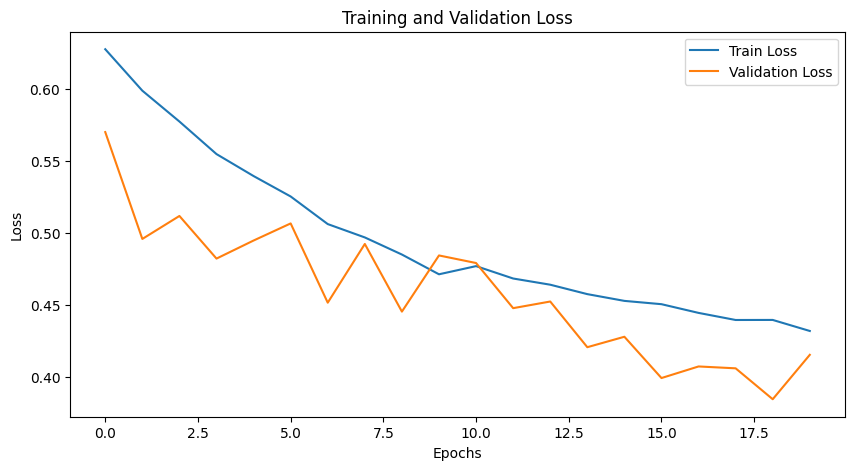

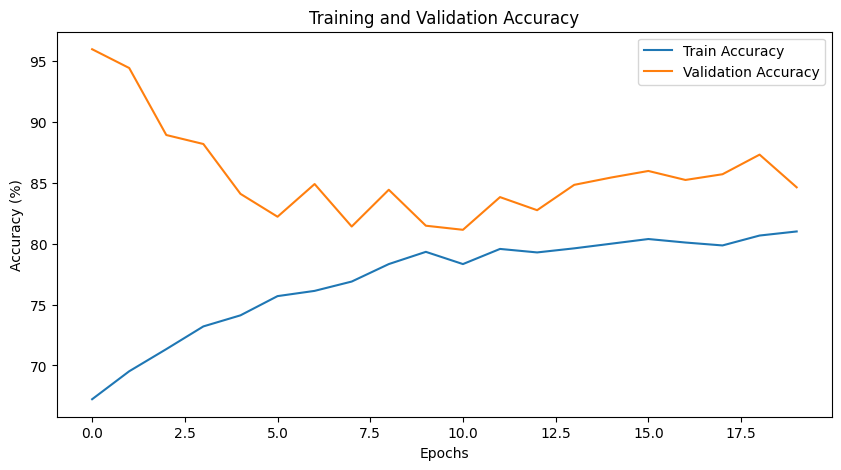

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.85      0.91      1431
     Class 1       0.16      0.68      0.26        59

    accuracy                           0.85      1490
   macro avg       0.57      0.77      0.59      1490
weighted avg       0.95      0.85      0.89      1490



CustomImageFeatureCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_image): Linear(in_features=32768, out_features=512, bias=True)
  (fc_metadata): Linear(in_features=9, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_combined): Linear(in_features=640, out_features=1, bias=True)
)

In [15]:
train_and_validate(model2,CNN_train_dataloader, CNN_val_dataloader, criterion, optimizer, epochs, device,best_model_path )

## Model 3

In [16]:
model3 = CustomImageFeatureCNN2(feature_input_size=9)  # Assuming 9 features for metadata
model3.to(device)
# Initialize optimizer
optimizer = optim.SGD(model3.parameters(), lr=0.0001,weight_decay=1e-4)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_size = 32
best_model_path = "best_model3.pth"

In [17]:
CNN_train_dataloader = DataLoader(CNN_train_dataset, batch_size=batch_size, shuffle=True)
CNN_val_dataloader = DataLoader(CNN_val_dataset, batch_size=batch_size, shuffle=True)

Epoch 1/20


Validating Epoch 1: 100%|██████████| 47/47 [00:37<00:00,  1.25it/s, val_loss=0.569]


Epoch [0/20], Train Loss: 0.6399, Val Loss: 0.5689, Val Accuracy: 95.91%, Val AUROC: 0.6144, Partial AUROC: 0.0319
Epoch 2/20


Validating Epoch 2: 100%|██████████| 47/47 [00:41<00:00,  1.12it/s, val_loss=0.536]


Epoch [1/20], Train Loss: 0.6285, Val Loss: 0.5364, Val Accuracy: 96.04%, Val AUROC: 0.6355, Partial AUROC: 0.0391
Epoch 3/20


Validating Epoch 3: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, val_loss=0.522]


Epoch [2/20], Train Loss: 0.6212, Val Loss: 0.5219, Val Accuracy: 96.04%, Val AUROC: 0.6689, Partial AUROC: 0.0431
Epoch 4/20


Validating Epoch 4: 100%|██████████| 47/47 [00:42<00:00,  1.11it/s, val_loss=0.51] 


Epoch [3/20], Train Loss: 0.6132, Val Loss: 0.5100, Val Accuracy: 96.11%, Val AUROC: 0.6878, Partial AUROC: 0.0471
Epoch 5/20


Validating Epoch 5: 100%|██████████| 47/47 [00:39<00:00,  1.19it/s, val_loss=0.514]


Epoch [4/20], Train Loss: 0.6023, Val Loss: 0.5141, Val Accuracy: 96.17%, Val AUROC: 0.7038, Partial AUROC: 0.0465
Epoch 6/20


Validating Epoch 6: 100%|██████████| 47/47 [00:25<00:00,  1.88it/s, val_loss=0.5]  


Epoch [5/20], Train Loss: 0.6020, Val Loss: 0.4998, Val Accuracy: 96.17%, Val AUROC: 0.7137, Partial AUROC: 0.0486
Epoch 7/20


Validating Epoch 7: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s, val_loss=0.497]


Epoch [6/20], Train Loss: 0.6018, Val Loss: 0.4968, Val Accuracy: 96.04%, Val AUROC: 0.7155, Partial AUROC: 0.0510
Epoch 8/20


Validating Epoch 8: 100%|██████████| 47/47 [00:23<00:00,  2.01it/s, val_loss=0.491]


Epoch [7/20], Train Loss: 0.5989, Val Loss: 0.4915, Val Accuracy: 95.50%, Val AUROC: 0.7197, Partial AUROC: 0.0518
Epoch 9/20


Validating Epoch 9: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s, val_loss=0.484]


Epoch [8/20], Train Loss: 0.5926, Val Loss: 0.4844, Val Accuracy: 95.44%, Val AUROC: 0.7217, Partial AUROC: 0.0523
Epoch 10/20


Validating Epoch 10: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s, val_loss=0.46] 


Epoch [9/20], Train Loss: 0.5841, Val Loss: 0.4598, Val Accuracy: 95.97%, Val AUROC: 0.7264, Partial AUROC: 0.0528
Epoch 11/20


Validating Epoch 11: 100%|██████████| 47/47 [00:22<00:00,  2.07it/s, val_loss=0.48] 


Epoch [10/20], Train Loss: 0.5844, Val Loss: 0.4802, Val Accuracy: 94.77%, Val AUROC: 0.7367, Partial AUROC: 0.0524
Epoch 12/20


Validating Epoch 12: 100%|██████████| 47/47 [00:18<00:00,  2.48it/s, val_loss=0.485]


Epoch [11/20], Train Loss: 0.5852, Val Loss: 0.4847, Val Accuracy: 93.22%, Val AUROC: 0.7396, Partial AUROC: 0.0542
Epoch 13/20


Validating Epoch 13: 100%|██████████| 47/47 [00:25<00:00,  1.86it/s, val_loss=0.459]


Epoch [12/20], Train Loss: 0.5796, Val Loss: 0.4590, Val Accuracy: 94.90%, Val AUROC: 0.7420, Partial AUROC: 0.0535
Epoch 14/20


Validating Epoch 14: 100%|██████████| 47/47 [00:22<00:00,  2.12it/s, val_loss=0.465]


Epoch [13/20], Train Loss: 0.5730, Val Loss: 0.4654, Val Accuracy: 93.42%, Val AUROC: 0.7402, Partial AUROC: 0.0540
Epoch 15/20


Validating Epoch 15: 100%|██████████| 47/47 [00:17<00:00,  2.62it/s, val_loss=0.456]


Epoch [14/20], Train Loss: 0.5740, Val Loss: 0.4562, Val Accuracy: 93.29%, Val AUROC: 0.7453, Partial AUROC: 0.0545
Epoch 16/20


Validating Epoch 16: 100%|██████████| 47/47 [00:18<00:00,  2.48it/s, val_loss=0.464]


Epoch [15/20], Train Loss: 0.5700, Val Loss: 0.4640, Val Accuracy: 92.55%, Val AUROC: 0.7510, Partial AUROC: 0.0556
Epoch 17/20


Validating Epoch 17: 100%|██████████| 47/47 [00:22<00:00,  2.13it/s, val_loss=0.453]


Epoch [16/20], Train Loss: 0.5710, Val Loss: 0.4531, Val Accuracy: 92.48%, Val AUROC: 0.7481, Partial AUROC: 0.0542
Epoch 18/20


Validating Epoch 18: 100%|██████████| 47/47 [00:18<00:00,  2.50it/s, val_loss=0.451]


Epoch [17/20], Train Loss: 0.5693, Val Loss: 0.4507, Val Accuracy: 92.42%, Val AUROC: 0.7562, Partial AUROC: 0.0552
Epoch 19/20


Validating Epoch 19: 100%|██████████| 47/47 [00:17<00:00,  2.66it/s, val_loss=0.437]


Epoch [18/20], Train Loss: 0.5619, Val Loss: 0.4367, Val Accuracy: 93.22%, Val AUROC: 0.7566, Partial AUROC: 0.0554
Epoch 20/20


Validating Epoch 20: 100%|██████████| 47/47 [00:25<00:00,  1.83it/s, val_loss=0.445]


Epoch [19/20], Train Loss: 0.5557, Val Loss: 0.4446, Val Accuracy: 92.15%, Val AUROC: 0.7592, Partial AUROC: 0.0553
Best Epoch: 19, Best Validation Loss: 0.4367
Training Complete


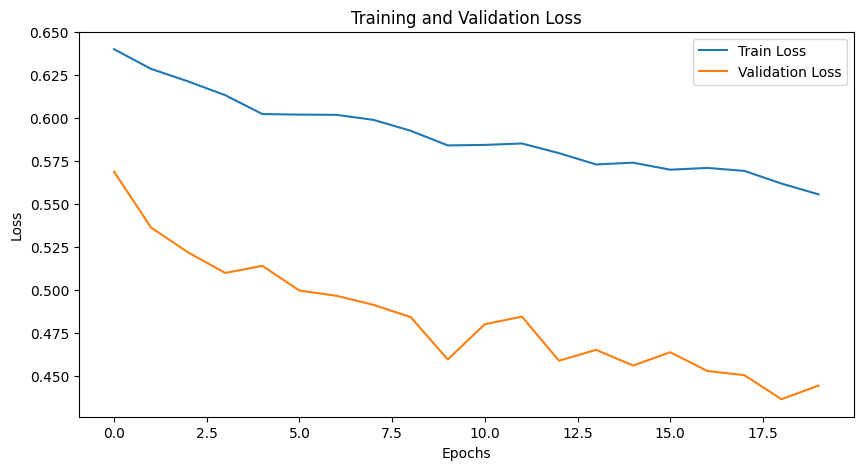

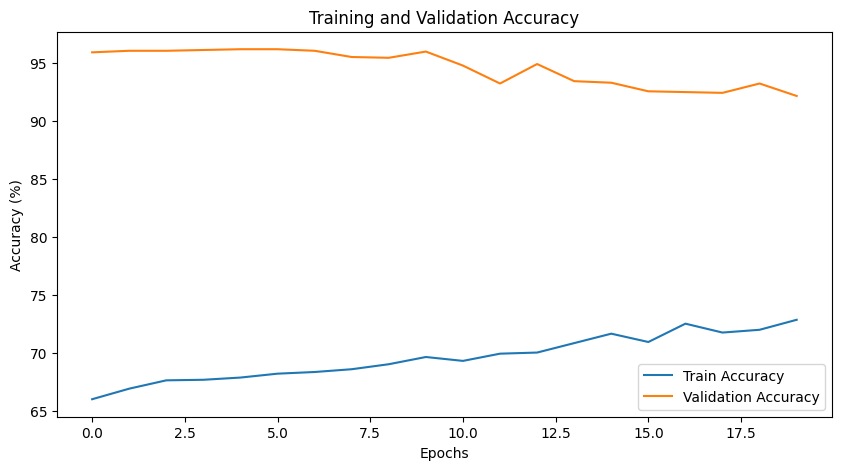

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96      1431
     Class 1       0.19      0.31      0.24        59

    accuracy                           0.92      1490
   macro avg       0.58      0.63      0.60      1490
weighted avg       0.94      0.92      0.93      1490



CustomImageFeatureCNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_image): Linear(in_features=32768, out_features=512, bias=True)
  (fc_metadata): Linear(in_features=9, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_combined): Linear(in_features=640, out_features=1, bias=True)
)

In [18]:
train_and_validate(model3,CNN_train_dataloader, CNN_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Model 4

In [19]:
model4 = CustomImageFeatureResNet(feature_input_size=9)  # Assuming 9 features for metadata
model4.to(device)
# Initialize optimizer
optimizer = optim.Adam(model4.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
best_model_path = "best_model4.pth"

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 24/24 [01:28<00:00,  3.67s/it, val_loss=0.567]


Epoch [0/20], Train Loss: 0.4739, Val Loss: 0.5675, Val Accuracy: 80.54%, Val AUROC: 0.7634, Partial AUROC: 0.0691
Epoch 2/20


Validating Epoch 2: 100%|██████████| 24/24 [01:22<00:00,  3.43s/it, val_loss=0.336]


Epoch [1/20], Train Loss: 0.3508, Val Loss: 0.3355, Val Accuracy: 88.99%, Val AUROC: 0.7413, Partial AUROC: 0.0491
Epoch 3/20


Validating Epoch 3: 100%|██████████| 24/24 [01:28<00:00,  3.67s/it, val_loss=0.398]


Epoch [2/20], Train Loss: 0.3015, Val Loss: 0.3976, Val Accuracy: 79.46%, Val AUROC: 0.8102, Partial AUROC: 0.0917
Epoch 4/20


Validating Epoch 4: 100%|██████████| 24/24 [01:26<00:00,  3.61s/it, val_loss=0.32] 


Epoch [3/20], Train Loss: 0.2492, Val Loss: 0.3196, Val Accuracy: 86.31%, Val AUROC: 0.7434, Partial AUROC: 0.0684
Epoch 5/20


Validating Epoch 5: 100%|██████████| 24/24 [01:27<00:00,  3.65s/it, val_loss=0.259]


Epoch [4/20], Train Loss: 0.2279, Val Loss: 0.2589, Val Accuracy: 91.21%, Val AUROC: 0.8385, Partial AUROC: 0.0922
Epoch 6/20


Validating Epoch 6: 100%|██████████| 24/24 [01:33<00:00,  3.90s/it, val_loss=0.366]


Epoch [5/20], Train Loss: 0.1581, Val Loss: 0.3662, Val Accuracy: 86.78%, Val AUROC: 0.7717, Partial AUROC: 0.0584
Epoch 7/20


Validating Epoch 7: 100%|██████████| 24/24 [01:25<00:00,  3.57s/it, val_loss=0.398]


Epoch [6/20], Train Loss: 0.1701, Val Loss: 0.3978, Val Accuracy: 77.92%, Val AUROC: 0.7380, Partial AUROC: 0.0591
Epoch 8/20


Validating Epoch 8: 100%|██████████| 24/24 [01:23<00:00,  3.46s/it, val_loss=0.368]


Epoch [7/20], Train Loss: 0.1706, Val Loss: 0.3679, Val Accuracy: 84.77%, Val AUROC: 0.7922, Partial AUROC: 0.0746
Epoch 9/20


Validating Epoch 9: 100%|██████████| 24/24 [01:31<00:00,  3.83s/it, val_loss=0.456]


Epoch [8/20], Train Loss: 0.1159, Val Loss: 0.4561, Val Accuracy: 80.00%, Val AUROC: 0.8201, Partial AUROC: 0.0955
Epoch 10/20


Validating Epoch 10: 100%|██████████| 24/24 [01:23<00:00,  3.49s/it, val_loss=0.258]


Epoch [9/20], Train Loss: 0.1177, Val Loss: 0.2578, Val Accuracy: 89.40%, Val AUROC: 0.7430, Partial AUROC: 0.0672
Epoch 11/20


Validating Epoch 11: 100%|██████████| 24/24 [01:13<00:00,  3.08s/it, val_loss=0.527]


Epoch [10/20], Train Loss: 0.1078, Val Loss: 0.5266, Val Accuracy: 73.29%, Val AUROC: 0.7982, Partial AUROC: 0.0709
Epoch 12/20


Validating Epoch 12: 100%|██████████| 24/24 [01:45<00:00,  4.39s/it, val_loss=0.183]


Epoch [11/20], Train Loss: 0.0786, Val Loss: 0.1828, Val Accuracy: 93.02%, Val AUROC: 0.8238, Partial AUROC: 0.0840
Epoch 13/20


Validating Epoch 13: 100%|██████████| 24/24 [02:20<00:00,  5.87s/it, val_loss=0.292]


Epoch [12/20], Train Loss: 0.0714, Val Loss: 0.2925, Val Accuracy: 90.54%, Val AUROC: 0.7638, Partial AUROC: 0.0659
Epoch 14/20


Validating Epoch 14: 100%|██████████| 24/24 [02:03<00:00,  5.15s/it, val_loss=0.233]


Epoch [13/20], Train Loss: 0.0764, Val Loss: 0.2325, Val Accuracy: 91.74%, Val AUROC: 0.7967, Partial AUROC: 0.0725
Epoch 15/20


Validating Epoch 15: 100%|██████████| 24/24 [02:00<00:00,  5.01s/it, val_loss=0.378]


Epoch [14/20], Train Loss: 0.0652, Val Loss: 0.3783, Val Accuracy: 84.63%, Val AUROC: 0.7758, Partial AUROC: 0.0631
Epoch 16/20


Validating Epoch 16: 100%|██████████| 24/24 [02:06<00:00,  5.27s/it, val_loss=0.18] 


Epoch [15/20], Train Loss: 0.0704, Val Loss: 0.1804, Val Accuracy: 93.56%, Val AUROC: 0.8074, Partial AUROC: 0.0833
Epoch 17/20


Validating Epoch 17: 100%|██████████| 24/24 [01:55<00:00,  4.80s/it, val_loss=0.242]


Epoch [16/20], Train Loss: 0.0362, Val Loss: 0.2416, Val Accuracy: 93.22%, Val AUROC: 0.7827, Partial AUROC: 0.0742
Epoch 18/20


Validating Epoch 18: 100%|██████████| 24/24 [02:14<00:00,  5.61s/it, val_loss=0.246]


Epoch [17/20], Train Loss: 0.0648, Val Loss: 0.2462, Val Accuracy: 93.15%, Val AUROC: 0.7440, Partial AUROC: 0.0623
Epoch 19/20


Validating Epoch 19: 100%|██████████| 24/24 [01:29<00:00,  3.73s/it, val_loss=0.416]


Epoch [18/20], Train Loss: 0.0355, Val Loss: 0.4160, Val Accuracy: 82.82%, Val AUROC: 0.7396, Partial AUROC: 0.0643
Epoch 20/20


Validating Epoch 20: 100%|██████████| 24/24 [02:36<00:00,  6.51s/it, val_loss=0.229]


Epoch [19/20], Train Loss: 0.0653, Val Loss: 0.2292, Val Accuracy: 92.48%, Val AUROC: 0.7764, Partial AUROC: 0.0750
Best Epoch: 16, Best Validation Loss: 0.1804
Training Complete


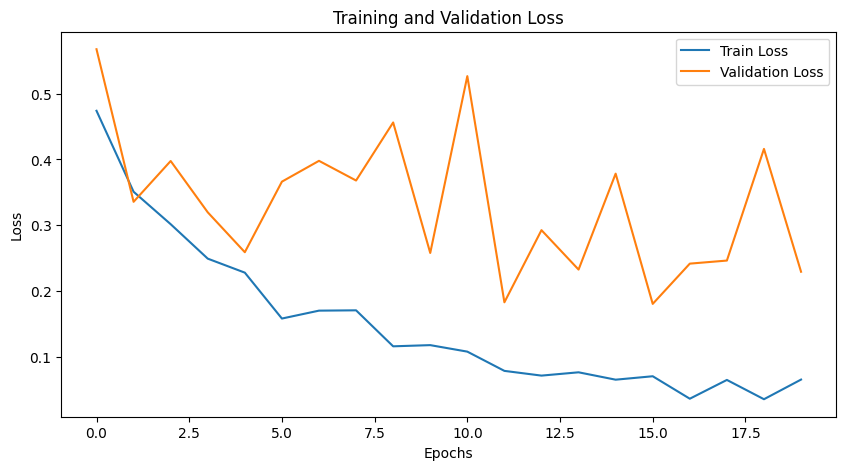

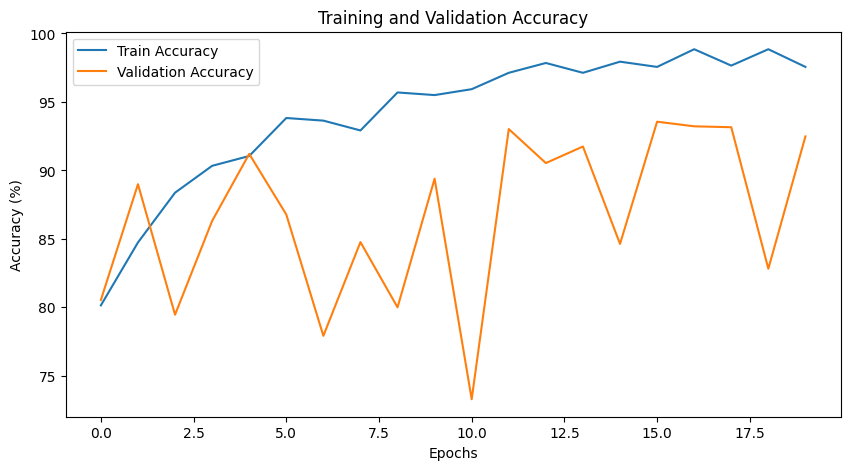

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.95      0.96      1431
     Class 1       0.24      0.42      0.31        59

    accuracy                           0.92      1490
   macro avg       0.61      0.68      0.63      1490
weighted avg       0.95      0.92      0.93      1490



CustomImageFeatureResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [20]:
train_and_validate(model4,resnet_train_dataloader, resnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Model 5

In [21]:
model5 = CustomImageFeatureResNet(feature_input_size=9)  # Assuming 9 features for metadata
model5.to(device)
# Initialize optimizer
optimizer = optim.SGD(model5.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
best_model_path = "best_model5.pth"

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 24/24 [01:58<00:00,  4.95s/it, val_loss=0.57] 


Epoch [0/20], Train Loss: 0.6705, Val Loss: 0.5696, Val Accuracy: 96.04%, Val AUROC: 0.5256, Partial AUROC: 0.0269
Epoch 2/20


Validating Epoch 2: 100%|██████████| 24/24 [02:28<00:00,  6.17s/it, val_loss=0.545]


Epoch [1/20], Train Loss: 0.6498, Val Loss: 0.5453, Val Accuracy: 96.04%, Val AUROC: 0.5536, Partial AUROC: 0.0261
Epoch 3/20


Validating Epoch 3: 100%|██████████| 24/24 [01:56<00:00,  4.85s/it, val_loss=0.526]


Epoch [2/20], Train Loss: 0.6292, Val Loss: 0.5257, Val Accuracy: 96.04%, Val AUROC: 0.5678, Partial AUROC: 0.0274
Epoch 4/20


Validating Epoch 4: 100%|██████████| 24/24 [01:27<00:00,  3.65s/it, val_loss=0.522]


Epoch [3/20], Train Loss: 0.6248, Val Loss: 0.5224, Val Accuracy: 96.04%, Val AUROC: 0.5870, Partial AUROC: 0.0279
Epoch 5/20


Validating Epoch 5: 100%|██████████| 24/24 [01:28<00:00,  3.68s/it, val_loss=0.516]


Epoch [4/20], Train Loss: 0.6084, Val Loss: 0.5164, Val Accuracy: 96.04%, Val AUROC: 0.6024, Partial AUROC: 0.0290
Epoch 6/20


Validating Epoch 6: 100%|██████████| 24/24 [01:31<00:00,  3.79s/it, val_loss=0.511]


Epoch [5/20], Train Loss: 0.6098, Val Loss: 0.5107, Val Accuracy: 96.04%, Val AUROC: 0.6146, Partial AUROC: 0.0297
Epoch 7/20


Validating Epoch 7: 100%|██████████| 24/24 [01:26<00:00,  3.58s/it, val_loss=0.505]


Epoch [6/20], Train Loss: 0.6022, Val Loss: 0.5051, Val Accuracy: 96.04%, Val AUROC: 0.6275, Partial AUROC: 0.0301
Epoch 8/20


Validating Epoch 8: 100%|██████████| 24/24 [01:27<00:00,  3.64s/it, val_loss=0.511]


Epoch [7/20], Train Loss: 0.6014, Val Loss: 0.5106, Val Accuracy: 96.04%, Val AUROC: 0.6324, Partial AUROC: 0.0306
Epoch 9/20


Validating Epoch 9: 100%|██████████| 24/24 [01:26<00:00,  3.60s/it, val_loss=0.506]


Epoch [8/20], Train Loss: 0.5781, Val Loss: 0.5055, Val Accuracy: 96.04%, Val AUROC: 0.6483, Partial AUROC: 0.0316
Epoch 10/20


Validating Epoch 10: 100%|██████████| 24/24 [01:20<00:00,  3.36s/it, val_loss=0.502]


Epoch [9/20], Train Loss: 0.5752, Val Loss: 0.5022, Val Accuracy: 95.97%, Val AUROC: 0.6594, Partial AUROC: 0.0322
Epoch 11/20


Validating Epoch 11: 100%|██████████| 24/24 [01:27<00:00,  3.64s/it, val_loss=0.499]


Epoch [10/20], Train Loss: 0.5743, Val Loss: 0.4994, Val Accuracy: 95.97%, Val AUROC: 0.6636, Partial AUROC: 0.0331
Epoch 12/20


Validating Epoch 12: 100%|██████████| 24/24 [01:31<00:00,  3.82s/it, val_loss=0.501]


Epoch [11/20], Train Loss: 0.5661, Val Loss: 0.5010, Val Accuracy: 95.97%, Val AUROC: 0.6720, Partial AUROC: 0.0331
Epoch 13/20


Validating Epoch 13: 100%|██████████| 24/24 [01:20<00:00,  3.34s/it, val_loss=0.502]


Epoch [12/20], Train Loss: 0.5532, Val Loss: 0.5025, Val Accuracy: 95.91%, Val AUROC: 0.6800, Partial AUROC: 0.0363
Epoch 14/20


Validating Epoch 14: 100%|██████████| 24/24 [01:24<00:00,  3.51s/it, val_loss=0.495]


Epoch [13/20], Train Loss: 0.5518, Val Loss: 0.4952, Val Accuracy: 95.97%, Val AUROC: 0.6843, Partial AUROC: 0.0357
Epoch 15/20


Validating Epoch 15: 100%|██████████| 24/24 [01:31<00:00,  3.82s/it, val_loss=0.494]


Epoch [14/20], Train Loss: 0.5409, Val Loss: 0.4942, Val Accuracy: 95.84%, Val AUROC: 0.6906, Partial AUROC: 0.0363
Epoch 16/20


Validating Epoch 16: 100%|██████████| 24/24 [01:26<00:00,  3.62s/it, val_loss=0.488]


Epoch [15/20], Train Loss: 0.5306, Val Loss: 0.4885, Val Accuracy: 95.64%, Val AUROC: 0.6979, Partial AUROC: 0.0383
Epoch 17/20


Validating Epoch 17: 100%|██████████| 24/24 [01:19<00:00,  3.30s/it, val_loss=0.484]


Epoch [16/20], Train Loss: 0.5278, Val Loss: 0.4835, Val Accuracy: 95.64%, Val AUROC: 0.7056, Partial AUROC: 0.0387
Epoch 18/20


Validating Epoch 18: 100%|██████████| 24/24 [01:26<00:00,  3.62s/it, val_loss=0.482]


Epoch [17/20], Train Loss: 0.5221, Val Loss: 0.4823, Val Accuracy: 95.50%, Val AUROC: 0.7090, Partial AUROC: 0.0380
Epoch 19/20


Validating Epoch 19: 100%|██████████| 24/24 [02:38<00:00,  6.59s/it, val_loss=0.48] 


Epoch [18/20], Train Loss: 0.5129, Val Loss: 0.4799, Val Accuracy: 95.44%, Val AUROC: 0.7179, Partial AUROC: 0.0388
Epoch 20/20


Validating Epoch 20: 100%|██████████| 24/24 [03:41<00:00,  9.23s/it, val_loss=0.477]


Epoch [19/20], Train Loss: 0.5041, Val Loss: 0.4769, Val Accuracy: 95.50%, Val AUROC: 0.7221, Partial AUROC: 0.0398
Best Epoch: 20, Best Validation Loss: 0.4769
Training Complete


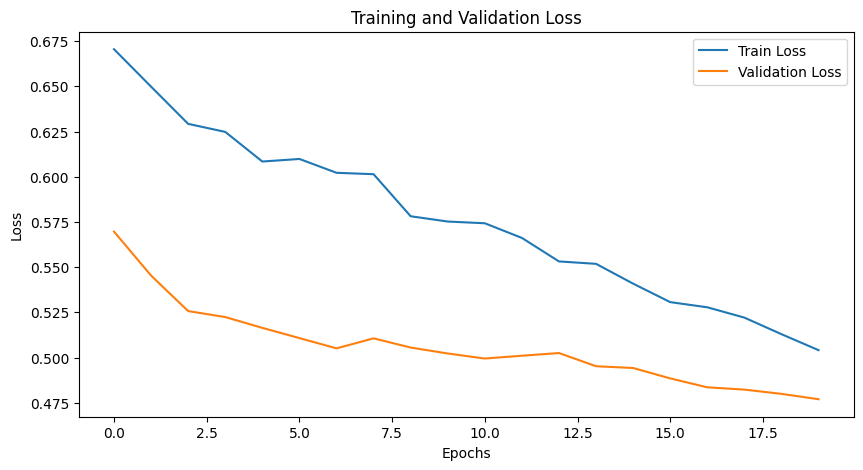

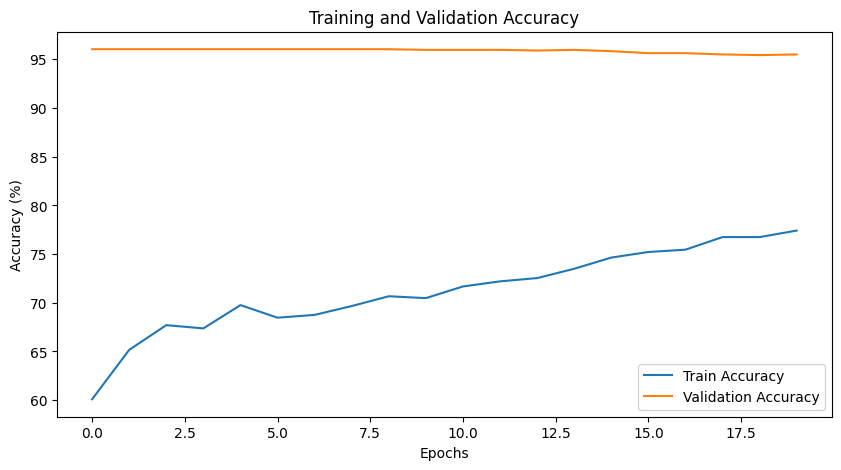

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.98      1431
     Class 1       0.30      0.10      0.15        59

    accuracy                           0.96      1490
   macro avg       0.63      0.55      0.56      1490
weighted avg       0.94      0.96      0.94      1490



CustomImageFeatureResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [22]:
train_and_validate(model5,resnet_train_dataloader, resnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Model 6

In [23]:
model6 = CustomImageFeatureResNet(feature_input_size=9)  # Assuming 9 features for metadata
model6.to(device)
# Initialize optimizer
optimizer = optim.SGD(model6.parameters(), lr=0.0001,weight_decay=1e-4)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_size = 32
best_model_path = "best_model6.pth"

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
resnet_train_dataloader = DataLoader(resnet_train_dataset, batch_size=batch_size, shuffle=True)
resnet_val_dataloader = DataLoader(resnet_val_dataset, batch_size=batch_size, shuffle=True)

Epoch 1/20


Validating Epoch 1: 100%|██████████| 47/47 [03:12<00:00,  4.10s/it, val_loss=0.725]


Epoch [0/20], Train Loss: 0.7365, Val Loss: 0.7252, Val Accuracy: 25.10%, Val AUROC: 0.5898, Partial AUROC: 0.0350
Epoch 2/20


Validating Epoch 2: 100%|██████████| 47/47 [01:51<00:00,  2.37s/it, val_loss=0.685]


Epoch [1/20], Train Loss: 0.7070, Val Loss: 0.6855, Val Accuracy: 58.93%, Val AUROC: 0.5779, Partial AUROC: 0.0277
Epoch 3/20


Validating Epoch 3: 100%|██████████| 47/47 [01:38<00:00,  2.09s/it, val_loss=0.662]


Epoch [2/20], Train Loss: 0.6774, Val Loss: 0.6620, Val Accuracy: 78.19%, Val AUROC: 0.5870, Partial AUROC: 0.0325
Epoch 4/20


Validating Epoch 4: 100%|██████████| 47/47 [02:23<00:00,  3.05s/it, val_loss=0.641]


Epoch [3/20], Train Loss: 0.6712, Val Loss: 0.6412, Val Accuracy: 89.06%, Val AUROC: 0.5699, Partial AUROC: 0.0250
Epoch 5/20


Validating Epoch 5: 100%|██████████| 47/47 [02:26<00:00,  3.11s/it, val_loss=0.623]


Epoch [4/20], Train Loss: 0.6582, Val Loss: 0.6230, Val Accuracy: 93.29%, Val AUROC: 0.5709, Partial AUROC: 0.0260
Epoch 6/20


Validating Epoch 6: 100%|██████████| 47/47 [01:51<00:00,  2.37s/it, val_loss=0.615]


Epoch [5/20], Train Loss: 0.6540, Val Loss: 0.6150, Val Accuracy: 94.16%, Val AUROC: 0.5798, Partial AUROC: 0.0272
Epoch 7/20


Validating Epoch 7: 100%|██████████| 47/47 [02:47<00:00,  3.56s/it, val_loss=0.604]


Epoch [6/20], Train Loss: 0.6458, Val Loss: 0.6037, Val Accuracy: 95.23%, Val AUROC: 0.5714, Partial AUROC: 0.0252
Epoch 8/20


Validating Epoch 8: 100%|██████████| 47/47 [02:46<00:00,  3.54s/it, val_loss=0.595]


Epoch [7/20], Train Loss: 0.6410, Val Loss: 0.5946, Val Accuracy: 95.70%, Val AUROC: 0.5800, Partial AUROC: 0.0254
Epoch 9/20


Validating Epoch 9: 100%|██████████| 47/47 [02:10<00:00,  2.77s/it, val_loss=0.588]


Epoch [8/20], Train Loss: 0.6388, Val Loss: 0.5883, Val Accuracy: 95.84%, Val AUROC: 0.5818, Partial AUROC: 0.0252
Epoch 10/20


Validating Epoch 10: 100%|██████████| 47/47 [01:23<00:00,  1.79s/it, val_loss=0.58] 


Epoch [9/20], Train Loss: 0.6303, Val Loss: 0.5796, Val Accuracy: 96.04%, Val AUROC: 0.5932, Partial AUROC: 0.0282
Epoch 11/20


Validating Epoch 11: 100%|██████████| 47/47 [02:06<00:00,  2.70s/it, val_loss=0.572]


Epoch [10/20], Train Loss: 0.6322, Val Loss: 0.5721, Val Accuracy: 96.11%, Val AUROC: 0.5961, Partial AUROC: 0.0276
Epoch 12/20


Validating Epoch 12: 100%|██████████| 47/47 [01:39<00:00,  2.12s/it, val_loss=0.562]


Epoch [11/20], Train Loss: 0.6275, Val Loss: 0.5623, Val Accuracy: 96.11%, Val AUROC: 0.5920, Partial AUROC: 0.0263
Epoch 13/20


Validating Epoch 13: 100%|██████████| 47/47 [02:05<00:00,  2.66s/it, val_loss=0.562]


Epoch [12/20], Train Loss: 0.6254, Val Loss: 0.5616, Val Accuracy: 96.17%, Val AUROC: 0.6024, Partial AUROC: 0.0301
Epoch 14/20


Validating Epoch 14: 100%|██████████| 47/47 [02:00<00:00,  2.57s/it, val_loss=0.56] 


Epoch [13/20], Train Loss: 0.6207, Val Loss: 0.5602, Val Accuracy: 96.11%, Val AUROC: 0.6045, Partial AUROC: 0.0297
Epoch 15/20


Validating Epoch 15: 100%|██████████| 47/47 [01:25<00:00,  1.82s/it, val_loss=0.558]


Epoch [14/20], Train Loss: 0.6232, Val Loss: 0.5582, Val Accuracy: 96.11%, Val AUROC: 0.6009, Partial AUROC: 0.0285
Epoch 16/20


Validating Epoch 16: 100%|██████████| 47/47 [01:22<00:00,  1.76s/it, val_loss=0.556]


Epoch [15/20], Train Loss: 0.6209, Val Loss: 0.5564, Val Accuracy: 96.11%, Val AUROC: 0.6137, Partial AUROC: 0.0289
Epoch 17/20


Validating Epoch 17: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it, val_loss=0.554]


Epoch [16/20], Train Loss: 0.6179, Val Loss: 0.5540, Val Accuracy: 96.11%, Val AUROC: 0.6156, Partial AUROC: 0.0277
Epoch 18/20


Validating Epoch 18: 100%|██████████| 47/47 [01:22<00:00,  1.76s/it, val_loss=0.552]


Epoch [17/20], Train Loss: 0.6176, Val Loss: 0.5519, Val Accuracy: 96.04%, Val AUROC: 0.6092, Partial AUROC: 0.0260
Epoch 19/20


Validating Epoch 19: 100%|██████████| 47/47 [01:19<00:00,  1.70s/it, val_loss=0.549]


Epoch [18/20], Train Loss: 0.6098, Val Loss: 0.5488, Val Accuracy: 96.11%, Val AUROC: 0.6211, Partial AUROC: 0.0298
Epoch 20/20


Validating Epoch 20: 100%|██████████| 47/47 [01:23<00:00,  1.78s/it, val_loss=0.549]


Epoch [19/20], Train Loss: 0.6163, Val Loss: 0.5489, Val Accuracy: 96.11%, Val AUROC: 0.6246, Partial AUROC: 0.0306
Best Epoch: 19, Best Validation Loss: 0.5488
Training Complete


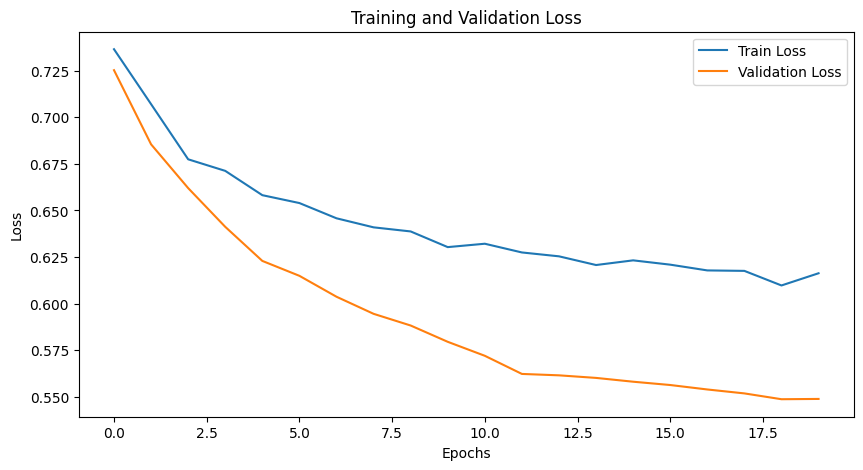

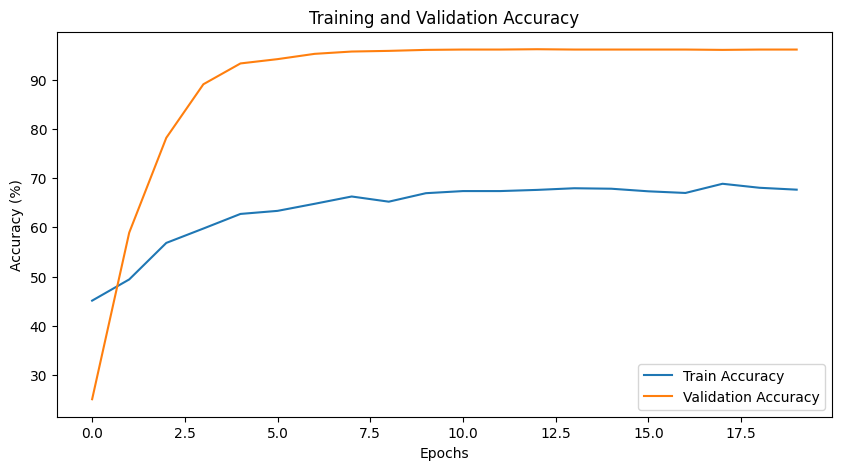

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98      1431
     Class 1       1.00      0.02      0.03        59

    accuracy                           0.96      1490
   macro avg       0.98      0.51      0.51      1490
weighted avg       0.96      0.96      0.94      1490



CustomImageFeatureResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [25]:
train_and_validate(model6,resnet_train_dataloader, resnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Model 7

In [26]:
model7 =  CustomImageFeatureEfficientNet(feature_input_size=9)  # Assuming 9 features for metadata
model7.to(device)
# Initialize optimizer
optimizer = optim.Adam(model7.parameters(), lr= 1.1621608010269284e-05)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_size = 16
best_model_path = "best_model7.pth"




/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
effnet_train_dataloader = DataLoader(effnet_train_dataset,  batch_size=batch_size, shuffle=True)
effnet_val_dataloader = DataLoader(effnet_val_dataset,  batch_size=batch_size, shuffle=True)

Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [01:39<00:00,  1.06s/it, val_loss=0.624]


Epoch [0/20], Train Loss: 0.6653, Val Loss: 0.6238, Val Accuracy: 85.03%, Val AUROC: 0.5190, Partial AUROC: 0.0248
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [01:15<00:00,  1.25it/s, val_loss=0.561]


Epoch [1/20], Train Loss: 0.6077, Val Loss: 0.5613, Val Accuracy: 91.28%, Val AUROC: 0.6415, Partial AUROC: 0.0523
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [01:15<00:00,  1.24it/s, val_loss=0.526]


Epoch [2/20], Train Loss: 0.5450, Val Loss: 0.5263, Val Accuracy: 89.33%, Val AUROC: 0.7150, Partial AUROC: 0.0620
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [01:14<00:00,  1.27it/s, val_loss=0.448]


Epoch [3/20], Train Loss: 0.4959, Val Loss: 0.4483, Val Accuracy: 90.40%, Val AUROC: 0.7604, Partial AUROC: 0.0666
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [01:13<00:00,  1.28it/s, val_loss=0.414]


Epoch [4/20], Train Loss: 0.4469, Val Loss: 0.4141, Val Accuracy: 89.26%, Val AUROC: 0.7891, Partial AUROC: 0.0740
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [01:17<00:00,  1.21it/s, val_loss=0.44] 


Epoch [5/20], Train Loss: 0.4128, Val Loss: 0.4404, Val Accuracy: 84.70%, Val AUROC: 0.8196, Partial AUROC: 0.0824
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:52<00:00,  1.79it/s, val_loss=0.412]


Epoch [6/20], Train Loss: 0.3726, Val Loss: 0.4124, Val Accuracy: 85.84%, Val AUROC: 0.8262, Partial AUROC: 0.0850
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [01:13<00:00,  1.27it/s, val_loss=0.368]


Epoch [7/20], Train Loss: 0.3649, Val Loss: 0.3682, Val Accuracy: 87.38%, Val AUROC: 0.8312, Partial AUROC: 0.0893
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [01:14<00:00,  1.25it/s, val_loss=0.342]


Epoch [8/20], Train Loss: 0.3337, Val Loss: 0.3420, Val Accuracy: 87.65%, Val AUROC: 0.8349, Partial AUROC: 0.0849
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [01:04<00:00,  1.47it/s, val_loss=0.356]


Epoch [9/20], Train Loss: 0.3074, Val Loss: 0.3557, Val Accuracy: 85.17%, Val AUROC: 0.8424, Partial AUROC: 0.0945
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [01:17<00:00,  1.21it/s, val_loss=0.339]


Epoch [10/20], Train Loss: 0.3117, Val Loss: 0.3386, Val Accuracy: 86.38%, Val AUROC: 0.8504, Partial AUROC: 0.0984
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [01:00<00:00,  1.54it/s, val_loss=0.348]


Epoch [11/20], Train Loss: 0.2876, Val Loss: 0.3480, Val Accuracy: 84.77%, Val AUROC: 0.8519, Partial AUROC: 0.1023
Epoch 13/20


Validating Epoch 13: 100%|██████████| 94/94 [01:12<00:00,  1.29it/s, val_loss=0.312]


Epoch [12/20], Train Loss: 0.2600, Val Loss: 0.3124, Val Accuracy: 85.64%, Val AUROC: 0.8514, Partial AUROC: 0.0994
Epoch 14/20


Validating Epoch 14: 100%|██████████| 94/94 [00:53<00:00,  1.75it/s, val_loss=0.283]


Epoch [13/20], Train Loss: 0.2573, Val Loss: 0.2826, Val Accuracy: 89.19%, Val AUROC: 0.8584, Partial AUROC: 0.1038
Epoch 15/20


Validating Epoch 15: 100%|██████████| 94/94 [01:06<00:00,  1.42it/s, val_loss=0.274]


Epoch [14/20], Train Loss: 0.2578, Val Loss: 0.2743, Val Accuracy: 88.99%, Val AUROC: 0.8578, Partial AUROC: 0.1049
Epoch 16/20


Validating Epoch 16: 100%|██████████| 94/94 [01:12<00:00,  1.29it/s, val_loss=0.267]


Epoch [15/20], Train Loss: 0.2406, Val Loss: 0.2668, Val Accuracy: 89.06%, Val AUROC: 0.8513, Partial AUROC: 0.1010
Epoch 17/20


Validating Epoch 17: 100%|██████████| 94/94 [01:02<00:00,  1.51it/s, val_loss=0.277]


Epoch [16/20], Train Loss: 0.2286, Val Loss: 0.2768, Val Accuracy: 88.46%, Val AUROC: 0.8439, Partial AUROC: 0.0954
Epoch 18/20


Validating Epoch 18: 100%|██████████| 94/94 [00:58<00:00,  1.61it/s, val_loss=0.241]


Epoch [17/20], Train Loss: 0.2313, Val Loss: 0.2406, Val Accuracy: 90.74%, Val AUROC: 0.8417, Partial AUROC: 0.0939
Epoch 19/20


Validating Epoch 19: 100%|██████████| 94/94 [01:04<00:00,  1.45it/s, val_loss=0.217]


Epoch [18/20], Train Loss: 0.2109, Val Loss: 0.2166, Val Accuracy: 92.08%, Val AUROC: 0.8535, Partial AUROC: 0.1034
Epoch 20/20


Validating Epoch 20: 100%|██████████| 94/94 [00:51<00:00,  1.84it/s, val_loss=0.281]


Epoch [19/20], Train Loss: 0.2044, Val Loss: 0.2810, Val Accuracy: 87.32%, Val AUROC: 0.8402, Partial AUROC: 0.0970
Best Epoch: 19, Best Validation Loss: 0.2166
Training Complete


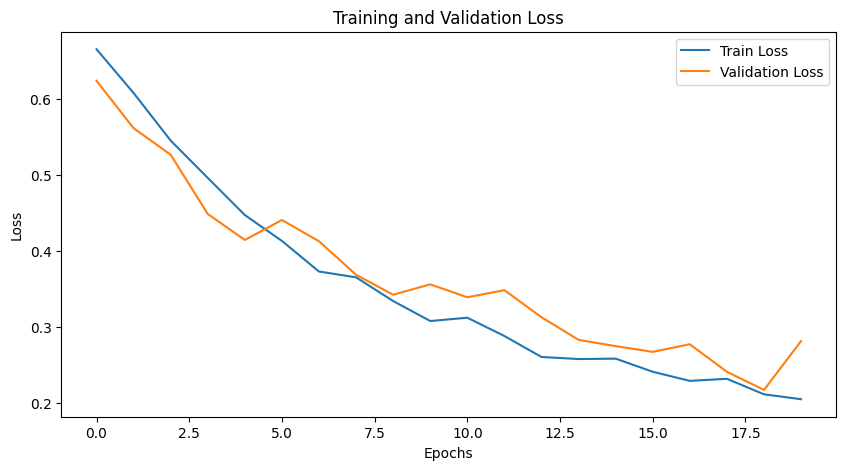

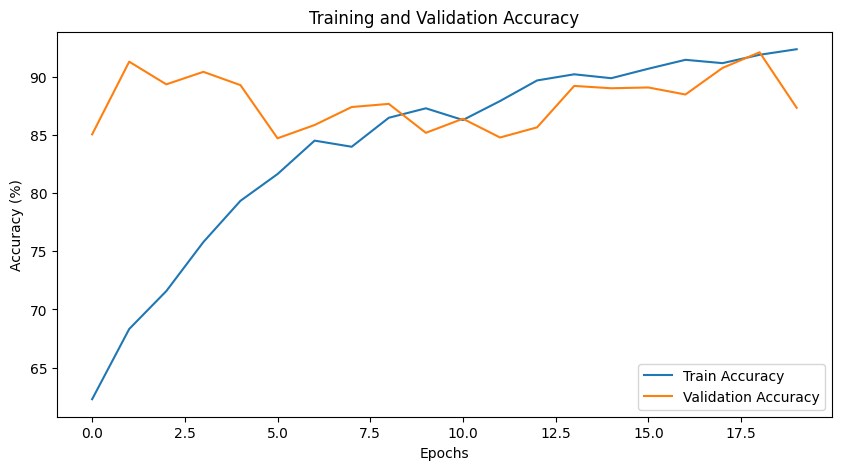

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.88      0.93      1431
     Class 1       0.18      0.64      0.29        59

    accuracy                           0.87      1490
   macro avg       0.58      0.76      0.61      1490
weighted avg       0.95      0.87      0.90      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [28]:
train_and_validate(model7,effnet_train_dataloader, effnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Model 8

In [29]:
model8 = CustomImageFeatureEfficientNet(feature_input_size=9)  # Assuming 9 features for metadata
model8.to(device)
# Initialize optimizer
optimizer = optim.SGD(model8.parameters(), lr=0.01)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
best_model_path = "best_model8.pth"

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s, val_loss=0.46] 


Epoch [0/20], Train Loss: 0.6159, Val Loss: 0.4601, Val Accuracy: 95.37%, Val AUROC: 0.6985, Partial AUROC: 0.0364
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [00:50<00:00,  1.85it/s, val_loss=0.417]


Epoch [1/20], Train Loss: 0.5513, Val Loss: 0.4175, Val Accuracy: 93.83%, Val AUROC: 0.7256, Partial AUROC: 0.0514
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [00:50<00:00,  1.85it/s, val_loss=0.441]


Epoch [2/20], Train Loss: 0.4937, Val Loss: 0.4410, Val Accuracy: 90.00%, Val AUROC: 0.7560, Partial AUROC: 0.0557
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [00:52<00:00,  1.80it/s, val_loss=0.418]


Epoch [3/20], Train Loss: 0.4435, Val Loss: 0.4181, Val Accuracy: 88.86%, Val AUROC: 0.8098, Partial AUROC: 0.0727
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [00:52<00:00,  1.79it/s, val_loss=0.411]


Epoch [4/20], Train Loss: 0.3950, Val Loss: 0.4110, Val Accuracy: 88.32%, Val AUROC: 0.8227, Partial AUROC: 0.0769
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s, val_loss=0.402]


Epoch [5/20], Train Loss: 0.3392, Val Loss: 0.4024, Val Accuracy: 84.16%, Val AUROC: 0.8389, Partial AUROC: 0.0866
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:52<00:00,  1.80it/s, val_loss=0.391]


Epoch [6/20], Train Loss: 0.3032, Val Loss: 0.3913, Val Accuracy: 84.36%, Val AUROC: 0.8484, Partial AUROC: 0.0918
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [00:52<00:00,  1.78it/s, val_loss=0.333]


Epoch [7/20], Train Loss: 0.2931, Val Loss: 0.3327, Val Accuracy: 87.99%, Val AUROC: 0.8634, Partial AUROC: 0.1028
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [00:54<00:00,  1.73it/s, val_loss=0.308]


Epoch [8/20], Train Loss: 0.2610, Val Loss: 0.3081, Val Accuracy: 88.26%, Val AUROC: 0.8684, Partial AUROC: 0.1020
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [00:51<00:00,  1.81it/s, val_loss=0.283]


Epoch [9/20], Train Loss: 0.2428, Val Loss: 0.2835, Val Accuracy: 89.66%, Val AUROC: 0.8852, Partial AUROC: 0.1167
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [00:51<00:00,  1.84it/s, val_loss=0.303]


Epoch [10/20], Train Loss: 0.2297, Val Loss: 0.3025, Val Accuracy: 88.05%, Val AUROC: 0.8682, Partial AUROC: 0.1011
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [01:00<00:00,  1.57it/s, val_loss=0.228]


Epoch [11/20], Train Loss: 0.1944, Val Loss: 0.2279, Val Accuracy: 91.28%, Val AUROC: 0.8819, Partial AUROC: 0.1166
Epoch 13/20


Validating Epoch 13: 100%|██████████| 94/94 [00:55<00:00,  1.69it/s, val_loss=0.269]


Epoch [12/20], Train Loss: 0.1682, Val Loss: 0.2695, Val Accuracy: 89.53%, Val AUROC: 0.8395, Partial AUROC: 0.0838
Epoch 14/20


Validating Epoch 14: 100%|██████████| 94/94 [00:51<00:00,  1.81it/s, val_loss=0.232]


Epoch [13/20], Train Loss: 0.1816, Val Loss: 0.2322, Val Accuracy: 91.01%, Val AUROC: 0.8722, Partial AUROC: 0.1132
Epoch 15/20


Validating Epoch 15: 100%|██████████| 94/94 [00:50<00:00,  1.84it/s, val_loss=0.219]


Epoch [14/20], Train Loss: 0.1574, Val Loss: 0.2194, Val Accuracy: 91.61%, Val AUROC: 0.8603, Partial AUROC: 0.1037
Epoch 16/20


Validating Epoch 16: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s, val_loss=0.227]


Epoch [15/20], Train Loss: 0.1313, Val Loss: 0.2267, Val Accuracy: 90.74%, Val AUROC: 0.8573, Partial AUROC: 0.1118
Epoch 17/20


Validating Epoch 17: 100%|██████████| 94/94 [00:56<00:00,  1.66it/s, val_loss=0.21] 


Epoch [16/20], Train Loss: 0.1373, Val Loss: 0.2097, Val Accuracy: 92.01%, Val AUROC: 0.8591, Partial AUROC: 0.1083
Epoch 18/20


Validating Epoch 18: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s, val_loss=0.274]


Epoch [17/20], Train Loss: 0.1205, Val Loss: 0.2736, Val Accuracy: 89.40%, Val AUROC: 0.8619, Partial AUROC: 0.1053
Epoch 19/20


Validating Epoch 19: 100%|██████████| 94/94 [00:50<00:00,  1.85it/s, val_loss=0.23] 


Epoch [18/20], Train Loss: 0.1195, Val Loss: 0.2301, Val Accuracy: 90.87%, Val AUROC: 0.8657, Partial AUROC: 0.1158
Epoch 20/20


Validating Epoch 20: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s, val_loss=0.214]


Epoch [19/20], Train Loss: 0.1019, Val Loss: 0.2142, Val Accuracy: 91.48%, Val AUROC: 0.8567, Partial AUROC: 0.1095
Best Epoch: 17, Best Validation Loss: 0.2097
Training Complete


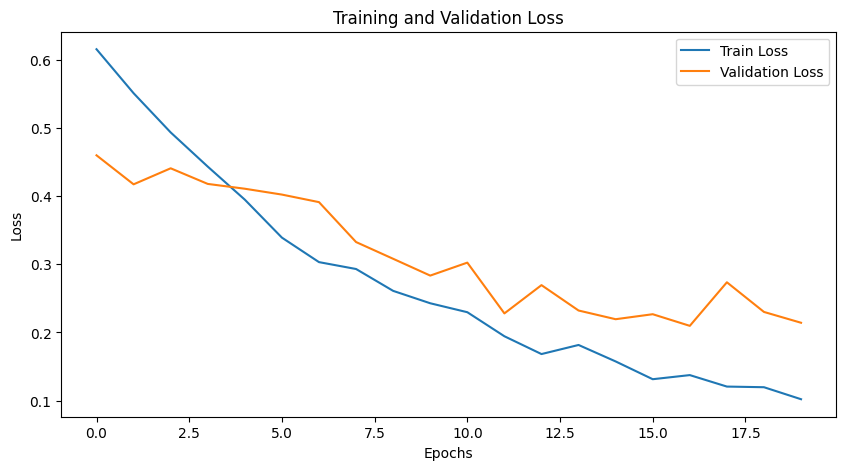

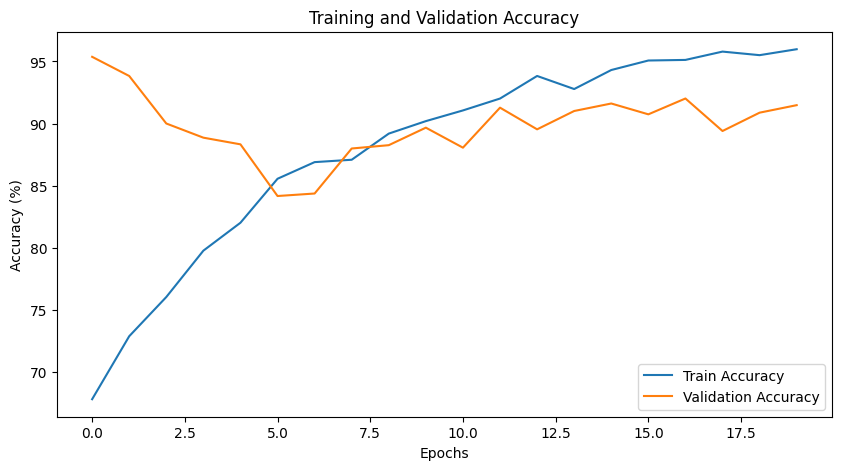

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.93      0.95      1431
     Class 1       0.25      0.56      0.34        59

    accuracy                           0.91      1490
   macro avg       0.61      0.74      0.65      1490
weighted avg       0.95      0.91      0.93      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [31]:
train_and_validate(model8,effnet_train_dataloader, effnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Model 9

In [32]:
model9 = CustomImageFeatureEfficientNet(feature_input_size=9)  # Assuming 9 features for metadata
model9.to(device)
# Initialize optimizer
optimizer = optim.Adam(model9.parameters(), lr=0.001)
# Define the loss function with the class weights
criterion = nn.BCELoss()  # Binary classification loss
# Set the number of epochs
epochs = 20
batch_sizes = 16
best_model_path = "best_model9.path"

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Validating Epoch 1: 100%|██████████| 94/94 [00:56<00:00,  1.68it/s, val_loss=0.376]


Epoch [0/20], Train Loss: 0.4325, Val Loss: 0.3763, Val Accuracy: 83.69%, Val AUROC: 0.8220, Partial AUROC: 0.0917
Epoch 2/20


Validating Epoch 2: 100%|██████████| 94/94 [00:50<00:00,  1.87it/s, val_loss=0.42] 


Epoch [1/20], Train Loss: 0.3475, Val Loss: 0.4196, Val Accuracy: 74.50%, Val AUROC: 0.8406, Partial AUROC: 0.0972
Epoch 3/20


Validating Epoch 3: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s, val_loss=0.392]


Epoch [2/20], Train Loss: 0.3192, Val Loss: 0.3923, Val Accuracy: 88.93%, Val AUROC: 0.7979, Partial AUROC: 0.0693
Epoch 4/20


Validating Epoch 4: 100%|██████████| 94/94 [01:00<00:00,  1.56it/s, val_loss=0.389]


Epoch [3/20], Train Loss: 0.3220, Val Loss: 0.3888, Val Accuracy: 88.79%, Val AUROC: 0.8398, Partial AUROC: 0.0894
Epoch 5/20


Validating Epoch 5: 100%|██████████| 94/94 [00:55<00:00,  1.69it/s, val_loss=0.26] 


Epoch [4/20], Train Loss: 0.2397, Val Loss: 0.2596, Val Accuracy: 89.60%, Val AUROC: 0.8398, Partial AUROC: 0.0857
Epoch 6/20


Validating Epoch 6: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s, val_loss=0.242]


Epoch [5/20], Train Loss: 0.1936, Val Loss: 0.2420, Val Accuracy: 89.73%, Val AUROC: 0.8615, Partial AUROC: 0.1131
Epoch 7/20


Validating Epoch 7: 100%|██████████| 94/94 [00:51<00:00,  1.81it/s, val_loss=0.173]


Epoch [6/20], Train Loss: 0.2082, Val Loss: 0.1731, Val Accuracy: 94.30%, Val AUROC: 0.8511, Partial AUROC: 0.0976
Epoch 8/20


Validating Epoch 8: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s, val_loss=0.329]


Epoch [7/20], Train Loss: 0.1571, Val Loss: 0.3290, Val Accuracy: 83.56%, Val AUROC: 0.8171, Partial AUROC: 0.0776
Epoch 9/20


Validating Epoch 9: 100%|██████████| 94/94 [00:50<00:00,  1.86it/s, val_loss=0.413]


Epoch [8/20], Train Loss: 0.1441, Val Loss: 0.4128, Val Accuracy: 80.40%, Val AUROC: 0.8423, Partial AUROC: 0.0984
Epoch 10/20


Validating Epoch 10: 100%|██████████| 94/94 [00:52<00:00,  1.79it/s, val_loss=0.422]


Epoch [9/20], Train Loss: 0.1439, Val Loss: 0.4219, Val Accuracy: 79.46%, Val AUROC: 0.8541, Partial AUROC: 0.1038
Epoch 11/20


Validating Epoch 11: 100%|██████████| 94/94 [00:54<00:00,  1.73it/s, val_loss=0.451]


Epoch [10/20], Train Loss: 0.1050, Val Loss: 0.4508, Val Accuracy: 90.27%, Val AUROC: 0.8261, Partial AUROC: 0.1017
Epoch 12/20


Validating Epoch 12: 100%|██████████| 94/94 [00:52<00:00,  1.80it/s, val_loss=0.211]


Epoch [11/20], Train Loss: 0.1091, Val Loss: 0.2113, Val Accuracy: 91.34%, Val AUROC: 0.8501, Partial AUROC: 0.1038
Early stopping triggered at epoch 11
Best Epoch: 7, Best Validation Loss: 0.1731
Training Complete


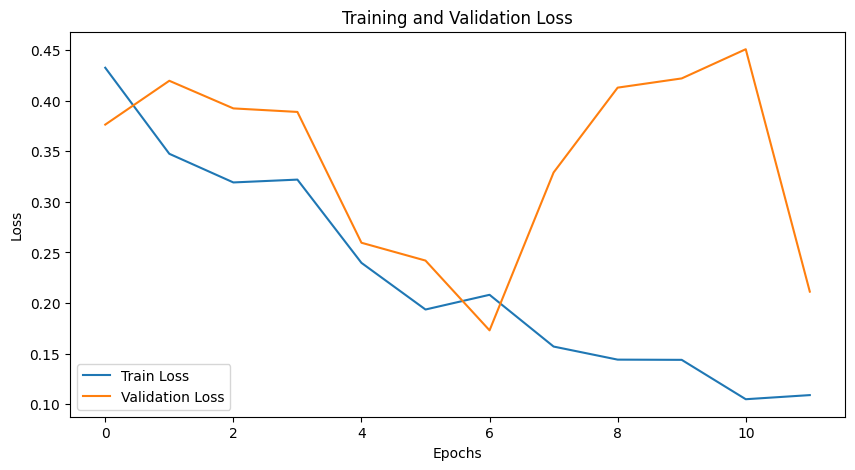

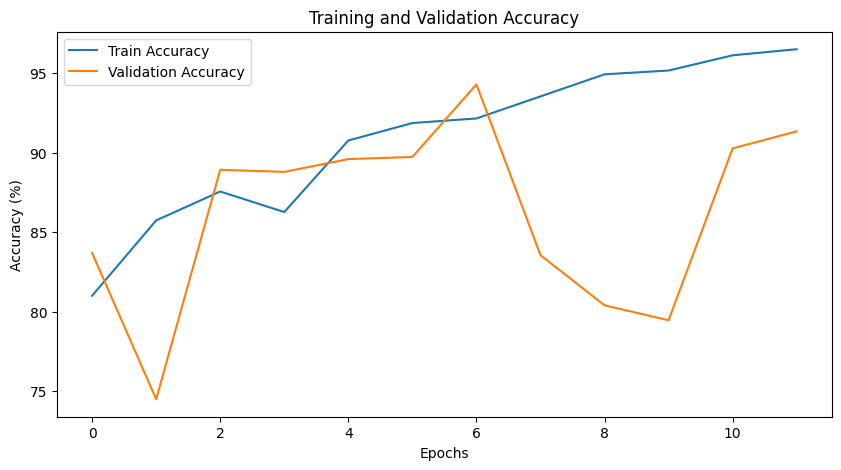

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.93      0.95      1431
     Class 1       0.22      0.46      0.30        59

    accuracy                           0.91      1490
   macro avg       0.60      0.69      0.62      1490
weighted avg       0.95      0.91      0.93      1490



CustomImageFeatureEfficientNet(
  (efficientnet): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
       

In [33]:
train_and_validate(model9,effnet_train_dataloader, effnet_val_dataloader, criterion, optimizer, epochs, device, best_model_path )

## Winning Model 

In [9]:
#create test dataset
effnet_test_dataset = MultiInputDataset(hdf5_file='../data/raw/test_image.hdf5', csv_file='../data/processed/processed-test-metadata1.csv', transform=get_normal_transform(resize_size=(128,128)))
# Create test DataLoader
effnet_test_dataloader = DataLoader(effnet_test_dataset,  batch_size=64, shuffle=True)

In [10]:
# Initialize the final model with 9 output features
final_model = CustomImageFeatureEfficientNet(9)

# Define the path to the saved model weights
final_model_path = "best_model7.pth"

# Load the model weights into final_model, mapping to CPU if necessary
final_model.load_state_dict(torch.load(final_model_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode, which disables dropout and batch normalization updates
final_model.eval()

# Initialize lists to store labels and predicted probabilities for later analysis
all_labels, all_probs = [], []

# Disable gradient computation for testing phase to save memory and improve performance
with torch.no_grad():
    # Loop through batches in the test dataloader
    for images, metadata, labels in effnet_test_dataloader:
        # Move data to the specified device (e.g., CPU or GPU) and adjust label shape
        images, metadata = images.to(device), metadata.to(device)
        labels = labels.float().to(device).unsqueeze(1)
        
        # Forward pass to get probabilities from the model
        probs = final_model(images, metadata)
        
        # Collect labels and predicted probabilities, converting to numpy arrays
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        
        # Generate binary predictions based on a 0.5 threshold
        predicted = (probs > 0.5).float()

    # Calculate the partial AUROC score (adjusted for your specific function)
    partial_auroc = score(np.array(all_labels), np.array(all_probs))
    print(f'The partial AUROC of the final model on the test images is {partial_auroc}')

    # Print the classification report, evaluating performance on Class 0 and Class 1
    print(classification_report(all_labels, (np.array(all_probs) >= 0.5).astype(int), target_names=['Class 0', 'Class 1']))

        
        
        

/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-sohka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1189445/1883220575.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blo

The partial auroc of the final model on the test image is 0.13625176183538829
              precision    recall  f1-score   support

     Class 0       0.98      0.92      0.95      1431
     Class 1       0.24      0.61      0.35        59

    accuracy                           0.91      1490
   macro avg       0.61      0.77      0.65      1490
weighted avg       0.95      0.91      0.93      1490

